In [1]:
import os
import glob
from tqdm import tqdm
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"figure.facecolor": (1,1,1,0)})
import yahist
import mplhep as hep
plt.style.use(hep.style.CMS)

from scipy.optimize import curve_fit

os.makedirs("thumbnails", exist_ok=True)
PLOTSDIR = "thumbnails"
LIMITDIR = "../../combine/vbswh/limits"
LHEDIR   = "../../analysis/studies/lhe_vbswh/output"
BABYDIR  = "../../analysis/studies/vbswh/output_btagsf_fix/Run2"

BLIND = False

In [2]:
from hepdata_lib import Submission, Table, Variable, Uncertainty

submission = Submission()

Cannot import ROOT: No module named 'ROOT'


# START: Exclusion plots

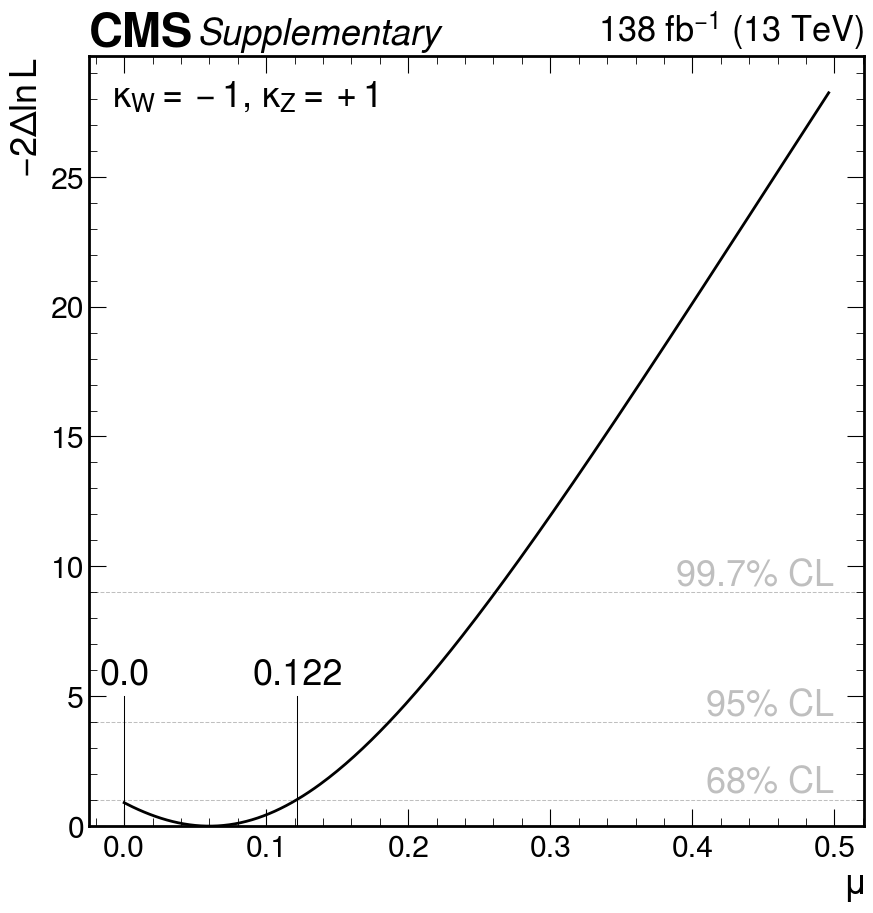

In [3]:
if not BLIND:
    result_1D = f"{LIMITDIR}/higgsCombine_vbswh_unblinded_coarse.MultiDimFit.mH125.root"

    with uproot.open(result_1D) as f:
        points = f.get("limit").arrays(["r", "deltaNLL"], library="np")
        points["deltaNLL"] *= 2


    r_argsort = np.argsort(points["r"])
    points["r"] = points["r"][r_argsort]
    points["deltaNLL"] = points["deltaNLL"][r_argsort]

    points["r"] = points["r"][:250]
    points["deltaNLL"] = points["deltaNLL"][:250]

    # Plot original curve
    fig, axes = plt.subplots()
    nans = np.isnan(points["deltaNLL"])
    axes.plot(points["r"][~nans], points["deltaNLL"][~nans], label="HiggsCombine", color="k", linewidth=2)

    x_high = axes.get_xticks()[-2]

    l_one_sigma_x = points["r"][points["deltaNLL"] <= 1][0]
    l_one_sigma_y = points["deltaNLL"][points["deltaNLL"] <= 1][0]

    r_one_sigma_x = points["r"][points["deltaNLL"] >= 1][0]
    r_one_sigma_y = points["deltaNLL"][points["deltaNLL"] >= 1][0]

    axes.plot([l_one_sigma_x, l_one_sigma_x], [0, 5], color="k", linewidth=0.75)
    axes.plot([r_one_sigma_x, r_one_sigma_x], [0, 5], color="k", linewidth=0.75)
    axes.text(l_one_sigma_x, 5.5, l_one_sigma_x, ha="center")
    axes.text(r_one_sigma_x, 5.5, r_one_sigma_x, ha="center")

#     axes.axhline(y=25, color="k", linestyle="--", alpha=0.5, linewidth=0.75)
#     axes.text(x_high, 25, r"$99.99\%$ CL", ha="right", va="bottom", alpha=0.5)

    axes.axhline(y=9,  color="k", linestyle="--", alpha=0.25, linewidth=0.75)
    axes.text(x_high,  9, r"$99.7\%$ CL", ha="right", va="bottom", alpha=0.25)

    axes.axhline(y=4,  color="k", linestyle="--", alpha=0.25, linewidth=0.75)
    axes.text(x_high,  4, r"$95\%$ CL", ha="right", va="bottom", alpha=0.25)

    axes.axhline(y=1,  color="k", linestyle="--", alpha=0.25, linewidth=0.75)
    axes.text(x_high,  1, r"$68\%$ CL", ha="right", va="bottom", alpha=0.25)

    axes.set_xlabel(r"$\mu$")
    axes.set_ylabel(r"$-2\Delta\ln{L}$")
    
    axes.set_ylim(bottom=0)

    # Add kW and kZ label
    axes.text(
        0.03, 0.97,
        r"$\kappa_W = -1$, $\kappa_Z = +1$",
        ha="left", va="top",
        transform = axes.transAxes
    )
    # Add CMS label
    hep.cms.label(
        "Supplementary",
        data=(not BLIND),
        lumi=138,
        loc=0,
        ax=axes
    );
    
    plt.savefig(f"{PLOTSDIR}/r_vs_m2deltaLogL_unblinded_zoom.pdf", bbox_inches="tight")

    
    # Create HEPData entry
    hepdata_r = Variable(
        "Signal strength",
        is_independent=True,
        is_binned=False,
        units=None
    )
    hepdata_r.values = points["r"][~nans]

    hepdata_deltaNLL = Variable(
        "-2DeltaLogL",
        is_independent=False,
        is_binned=False,
        units=None
    )
    hepdata_deltaNLL.values = points["deltaNLL"][~nans]

    table = Table("BSM 1D exclusion plot")
    table.description = "The exclusion significance in the BSM analysis with kW=-1, kZ=+1 plotted as a function of the signal strength"
    table.location = "Additional material"
    table.add_image(f"{PLOTSDIR}/r_vs_m2deltaLogL_unblinded_zoom.pdf")
    table.add_variable(hepdata_r)
    table.add_variable(hepdata_deltaNLL)

    submission.add_table(table)

In [4]:
def get_2D_results(results_2D_globber, blind=False):
    results_2D = glob.glob(results_2D_globber)
    r_eq_1_sigmas = []
    kW_points = []
    kZ_points = []
    kW_spec_points = []
    kZ_spec_points = []
    for combine_root_file in tqdm(results_2D):
        with uproot.open(combine_root_file) as f:
            points = f.get("limit").arrays(["r", "deltaNLL"], library="np")
            points["deltaNLL"] *= 2

        scan_name = combine_root_file.split("/")[-1].replace("m", "-").replace("p", ".").replace(".root", "")
        kW_points.append(float(scan_name.split("_")[2]))
        kZ_points.append(float(scan_name.split("_")[4]))

        r_eq_1_indices = np.where(points["r"] == 1)[0]
        if r_eq_1_indices.size == 0 or np.isnan(points["deltaNLL"][r_eq_1_indices[0]]):
            # Find largest exclusion value (ignore NaNs)
            max_excl_sigma_idx = np.nanargmax(points["deltaNLL"])
            max_excl_sigma = np.sqrt(points["deltaNLL"][max_excl_sigma_idx])
            if max_excl_sigma >= 2 and points["r"][max_excl_sigma_idx] < 1:
                # If the max exclusion is >= 2sigma and the corresponding r-value is less than one, then
                # the r-value of 1 is certainly excluded at some large value

                # Plot original curve
#                 fig, axes = plt.subplots()
                nans = np.isnan(points["deltaNLL"])
#                 axes.plot(points["r"][~nans], points["deltaNLL"][~nans], label="HiggsCombine")
                # Fit last 10 points to a log
                curve = lambda x, A, B, C: A*np.log(x + B) + C
                opt_params, _ = curve_fit(curve, points["r"][~nans][-10:], points["deltaNLL"][~nans][-10:])
                # Plot best fit
                A, B, C = opt_params
#                 axes.plot(
#                     np.linspace(0, 1.5, 31), 
#                     [curve(x, *opt_params) for x in np.linspace(0, 1.5, 31)], 
#                     color="k", alpha=0.25,
#                     label=(r"$A\log{(r B)} C$".replace("A", f"{A:0.1f}")
#                                               .replace("B", f"{B:+0.2f}")
#                                               .replace("C", f"{C:+0.1f}"))
#                 )
                # Plot best fit value at r = 1
#                 axes.scatter(
#                     1, curve(1, *opt_params), 
#                     marker="*", color="r", s=96, zorder=100, 
#                     label=r"inferred $r = 1$"
#                 )
#                 axes.set_xlabel("r");
#                 axes.set_ylabel(r"$-2\Delta\log{L}$");

                # Take best fit value at r = 1 as exclusion sigma
                r_eq_1_sigmas.append(np.sqrt(curve(1, *opt_params)))

                # Add kW and kZ label
#                 axes.text(
#                     0.03, 0.97,
#                     (r"$\kappa_W = KW$, $\kappa_Z = KZ$".replace("KW", f"{kW_points[-1]:.1f}")
#                                                         .replace("KZ", f"{kZ_points[-1]:.1f}")),
#                     ha="left", va="top",
#                     transform = axes.transAxes
#                 )
                # Add CMS label
#                 hep.cms.label(
#                     data=(not BLIND),
#                     lumi=138,
#                     loc=0,
#                     ax=axes
#                 );
#                 axes.legend(loc="lower right");

                kW_spec_points.append(kW_points[-1])
                kZ_spec_points.append(kZ_points[-1])
            else:
                # Otherwise, we are in trouble; let's diagnose!
                print(combine_root_file)
                print("Uh oh!")
                print(points["deltaNLL"][np.nanargmax(points["deltaNLL"])])
                print(points["r"])
                print(np.sqrt(points["deltaNLL"]))
                fig, axes = plt.subplots()
                axes.plot(points["r"], points["deltaNLL"])
                break
        else:
            r_eq_1_sigmas.append(np.sqrt(points["deltaNLL"][r_eq_1_indices[0]]))

    r_eq_1_sigmas = np.clip(np.array(r_eq_1_sigmas), 0, 10000)
    kW_points = np.array(kW_points)
    kZ_points = np.array(kZ_points)
    
    return r_eq_1_sigmas, kW_points, kZ_points, (kW_spec_points, kZ_spec_points)

In [5]:
import warnings
warnings.filterwarnings("ignore")
    
if BLIND:
    results = get_2D_results(f"{LIMITDIR}/results/*.root", blind=True)
    r_eq_1_sigmas, kW_points, kZ_points, spec_points = results
    kW_spec_points, kZ_spec_points = spec_points
else:
    results = get_2D_results(f"{LIMITDIR}/results_unblinded/*.root", blind=False)
    results_blind = get_2D_results(f"{LIMITDIR}/results/*.root", blind=False)
    r_eq_1_sigmas, kW_points, kZ_points, spec_points = results
    kW_spec_points, kZ_spec_points = spec_points
    r_eq_1_sigmas_blind, kW_points_blind, kZ_points_blind, spec_points = results_blind

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:08<00:00, 77.94it/s]


In [6]:
kW_values = np.unique(kW_points)
kW_widths = kW_values[1:] - kW_values[:-1]
kW_bin_edges = np.union1d(
    kW_values[:-1] + 0.5*kW_widths,
    kW_values[1:]  - 0.5*kW_widths,
)
kW_bin_edges = np.concatenate((
    [kW_values[0] - 0.5*kW_widths[0]],
    kW_bin_edges,
    [kW_values[-1] + 0.5*kW_widths[-1]]
))

kZ_values = np.unique(kZ_points)
kZ_widths = kZ_values[1:] - kZ_values[:-1]
kZ_bin_edges = np.union1d(
    kZ_values[:-1] + 0.5*kZ_widths,
    kZ_values[1:]  - 0.5*kZ_widths
)
kZ_bin_edges = np.concatenate((
    [kZ_values[0] - 0.5*kZ_widths[0]],
    kZ_bin_edges,
    [kZ_values[-1] + 0.5*kZ_widths[-1]]
))

In [7]:
def zero_out_sigmas(sigmas, kW_points, kZ_points, *kWkZ_to_zero, zero_val=0):
    filtered_sigmas = sigmas.copy()
    for kW, kZ in kWkZ_to_zero:
        filtered_sigmas[np.where((kW_points == kW) & (kZ_points == kZ))] = zero_val
        
    return np.array(filtered_sigmas)

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

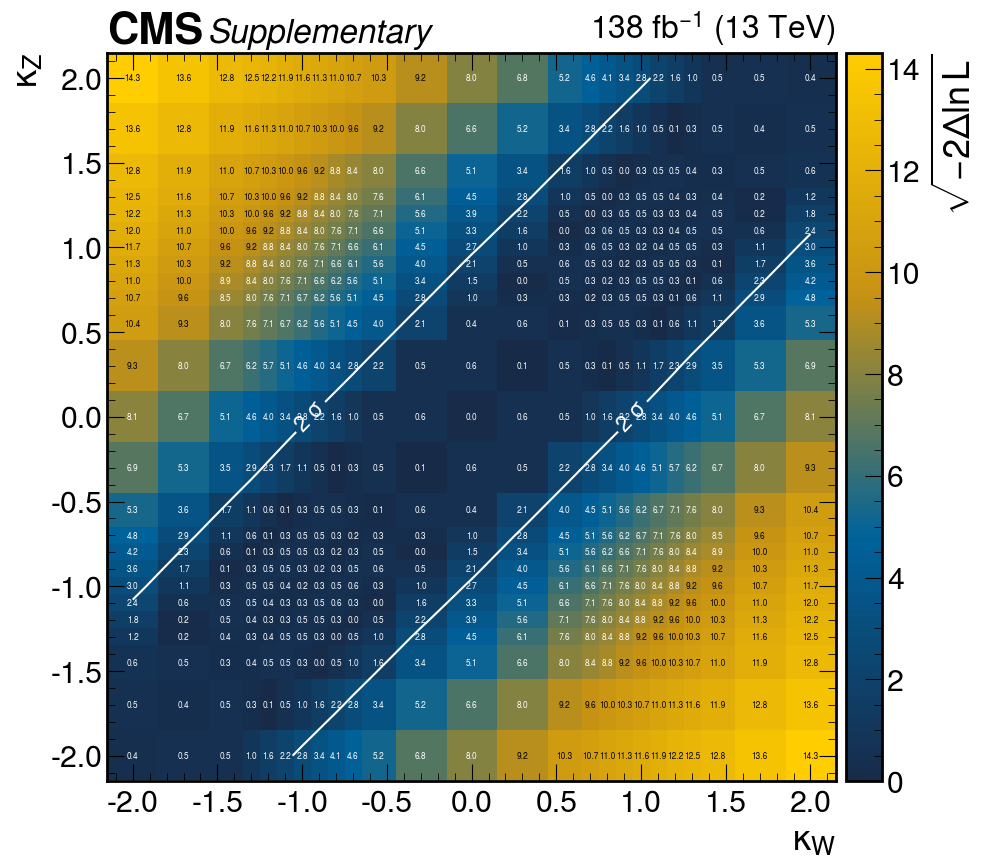

In [9]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=zero_out_sigmas(r_eq_1_sigmas, kW_points, kZ_points, (0,0))
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(
    ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6, cmap=cmap,
    hide_empty=False
);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
cbar = colorbar(mpl_objs[0]);
cbar.set_label(r"$\sqrt{-2\Delta\ln L}$", labelpad=10);


# Plot contour(s)
contours = axes.contour(
    np.unique(kW_points), np.unique(kZ_points), 
    hist2d.counts,
    [np.sqrt(6.18)],
    colors=["white"]
)

# Add CMS label
hep.cms.label(
    "Supplementary",
    data=(not BLIND),
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

if BLIND:
    axes.clabel(contours, contours.levels, inline=True, fmt=lambda x: f"2 $\sigma$", fontsize=16)
else:
    axes.clabel(contours, contours.levels, inline=True, fmt=lambda x: f"2 $\sigma$", fontsize=16);

axes.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);

if BLIND:
    plt.savefig(f"{PLOTSDIR}/raw_exclusion_2D.pdf", bbox_inches="tight");
else:
    plt.savefig(f"{PLOTSDIR}/raw_exclusion_2D_unblinded.pdf", bbox_inches="tight");
    
    
# Create HEPData entry
counter = 0
hepdata_kW_bins = []
hepdata_kZ_bins = []
hepdata_deltaNLL_values = []
for i, _kZ_bin in enumerate(np.stack([kZ_bin_edges[:-1], kZ_bin_edges[1:]]).T):
    for j, _kW_bin in enumerate(np.stack([kW_bin_edges[:-1], kW_bin_edges[1:]]).T):
        _deltaNLL = hist2d.counts[i][j]
        hepdata_kW_bins.append(_kW_bin)
        hepdata_kZ_bins.append(_kZ_bin)
        hepdata_deltaNLL_values.append(_deltaNLL)
        counter += 1

hepdata_kW = Variable("kW", is_independent=True, is_binned=True)
hepdata_kW.values = hepdata_kW_bins

hepdata_kZ = Variable("kZ", is_independent=True, is_binned=True)
hepdata_kZ.values = hepdata_kZ_bins

hepdata_deltaNLL = Variable("-2DeltaLogL", is_independent=False, is_binned=False)
hepdata_deltaNLL.values = hepdata_deltaNLL_values

table = Table("BSM 2D exclusion plot")
table.description = "The exclusion significance of signal strength = 1 in the BSM analysis plotted as a function of kW and kZ"
table.location = "Additional material"
table.add_image(f"{PLOTSDIR}/raw_exclusion_2D_unblinded.pdf")
table.add_variable(hepdata_kW)
table.add_variable(hepdata_kZ)
table.add_variable(hepdata_deltaNLL)

submission.add_table(table)

# END: Exclusion plots

# START: Data/MC histograms

In [10]:
import uproot
import os
import glob
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
import yahist
import mplhep as hep

from utils.analysis import Validation

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

In [11]:
presort_babies = sorted(glob.glob(f"{BABYDIR}/*.root"))
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby and "VVJJ" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
        
babies

['../../analysis/studies/vbswh/output_btagsf_fix/Run2/Bosons.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/SingleTop.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTX.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar1L.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar2L.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/VBSWH_kWkZscan.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/VBSWH_mkW.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/VH.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/WJets.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/data.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/EWKWLep.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/VBSWH_SM.root']

In [12]:
sig_babies = [baby for baby in presort_babies if "VBSWH_mkW" in baby]
data_babies = [baby for baby in babies if "data" in baby]
bkg_babies = [baby for baby in babies if "data" not in baby and "VBSWH" not in baby]

print(sig_babies)
print(data_babies)
bkg_babies

['../../analysis/studies/vbswh/output_btagsf_fix/Run2/VBSWH_mkW.root']
['../../analysis/studies/vbswh/output_btagsf_fix/Run2/data.root']


['../../analysis/studies/vbswh/output_btagsf_fix/Run2/Bosons.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/SingleTop.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTX.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar1L.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/TTbar2L.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/VH.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/WJets.root',
 '../../analysis/studies/vbswh/output_btagsf_fix/Run2/EWKWLep.root']

In [13]:
vbswh = Validation(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "light_btag_sf", "bc_btag_sf", 
        "pu_sf", "prefire_sf", "trig_sf", "puid_sf"
    ],
    plots_dir=None,
    sample_labels = {
        "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights",
    stack_order=["Bosons"]
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs_deta_jj > 3 and hbbjet_score > 0.3"
)
vbswh.df["SR_like"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9"
)

vbswh.df["regionA"] = vbswh.df.eval(
    "SR_like and abs_deta_jj > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "SR_like and abs_deta_jj <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "SR_like and abs_deta_jj <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionD"] = vbswh.df.eval(
    "SR_like and abs_deta_jj > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection(
#     "M_jj > 1500 and abs_deta_jj > 4 and passes_bveto and ST > 1200 and hbbjet_msoftdrop > 150 and hbbjet_score < 0.9"
# )
# vbswh.make_selection(
#     "passes_bveto and hbbjet_score < 0.9"
# )
# vbswh.make_selection("passes_bveto != True")

Loading data babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


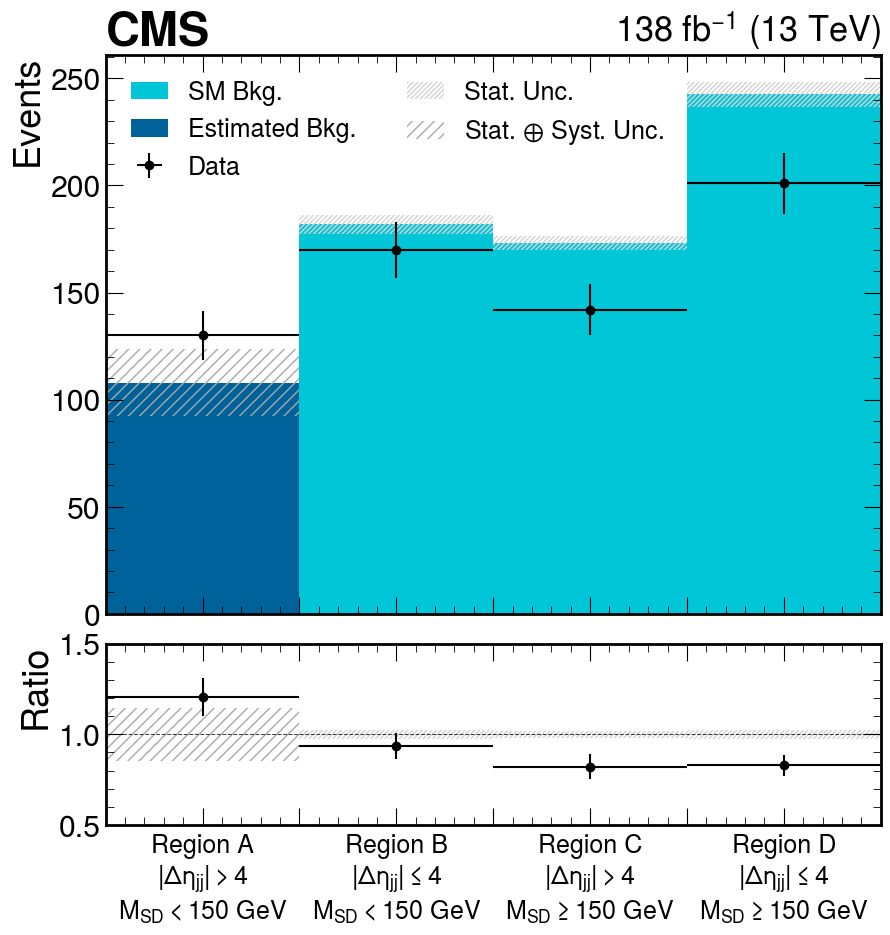

In [14]:
from matplotlib import gridspec

plot_ratio = True
prelim = False

trident_colors = {
    "navy": "#182B49",
    "blue": "#00629B", 
    "gold": "#C69214", 
    "yellow": "#FFCD00", 
    "cyan": "#00C6D7", 
    "sand": "#F5F0E6"
}

# mc_bin_color = "lightgrey"
# mc_err_color = (0.75, 0.75, 0.75)
# pred_bin_color = "darkgrey"
# pred_err_color = (0.5, 0.5, 0.5)
mc_bin_color = trident_colors["cyan"]
mc_err_color = "lightgrey"
mc_err_hatch = ""
pred_bin_color = trident_colors["blue"]
pred_err_color = "darkgrey"
pred_err_hatch = "///"

if plot_ratio:
    fig = plt.figure()
    gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
    axes = fig.add_subplot(gs[0])
    ratio_axes = fig.add_subplot(gs[1])
else:
    fig, axes = plt.subplots()

data_count_A = vbswh.data_count(selection="regionA") # (normally region C)
data_count_B = vbswh.data_count(selection="regionB") # (normally region D)
data_count_C = vbswh.data_count(selection="regionC") # (normally region B)
data_count_D = vbswh.data_count(selection="regionD") # (normally region A)

data_error_A = vbswh.data_error(selection="regionA") # (normally region C)
data_error_B = vbswh.data_error(selection="regionB") # (normally region D)
data_error_C = vbswh.data_error(selection="regionC") # (normally region B)
data_error_D = vbswh.data_error(selection="regionD") # (normally region A)

mc_count_A = vbswh.bkg_count(selection="regionA") #    (normally region C)
mc_count_B = vbswh.bkg_count(selection="regionB") #    (normally region D)
mc_count_C = vbswh.bkg_count(selection="regionC") #    (normally region B)
mc_count_D = vbswh.bkg_count(selection="regionD") # SR (normally region A)

mc_error_A = vbswh.bkg_error(selection="regionA") #    (normally region C)
mc_error_B = vbswh.bkg_error(selection="regionB") #    (normally region D)
mc_error_C = vbswh.bkg_error(selection="regionC") #    (normally region B)
mc_error_D = vbswh.bkg_error(selection="regionD") # SR (normally region A)

data_tf = data_count_A/data_count_B
mc_fix = (mc_count_D/mc_count_C)/(mc_count_A/mc_count_B)

data_pred_count = data_count_C*data_tf*(mc_fix)
abcd_stat = np.sqrt(1/data_count_A + 1/data_count_B + 1/data_count_C)
abcd_syst = np.sqrt(0.13**2 + 0.13**2)
data_pred_error = data_pred_count*data_tf*mc_fix*np.sqrt(abcd_stat**2 + abcd_syst**2)

mc = yahist.Hist1D.from_bincounts(
    [0, mc_count_C, mc_count_A, mc_count_B],
    errors=[0, mc_error_C, mc_error_A, mc_error_B]
)

data = yahist.Hist1D.from_bincounts(
    [data_count_D, data_count_C, data_count_A, data_count_B],
    errors=[data_error_D, data_error_C, data_error_A, data_error_B]
)

pred = yahist.Hist1D.from_bincounts(
    [data_pred_count, 0, 0, 0],
    errors=[data_pred_error, 0, 0, 0]
)

bkg = yahist.Hist1D.from_bincounts(
    [data_pred_count, mc_count_C, mc_count_A, mc_count_B],
    errors=[data_pred_error, mc_error_C, mc_error_A, mc_error_B]
)


mc.plot(ax=axes, linewidth=0, histtype="stepfilled", color=mc_bin_color, label="SM Bkg.", zorder=1.1)
# Plot MC errors
mc_counts = mc.counts
mc_counts[mc_counts == 0] = 1e-12
err_points = np.repeat(mc.edges, 2)[1:-1]
err_high = np.repeat(mc_counts + mc.errors, 2)
err_low = np.repeat(mc_counts - mc.errors, 2)
axes.fill_between(
    err_points, err_high, err_low,
    step="mid",
    hatch="///////",
    facecolor="none",
    edgecolor=mc_err_color,
    linewidth=0.0,
    linestyle="-",
    zorder=1.2,
    label="Stat. Unc."
)


pred.plot(ax=axes, linewidth=0, histtype="stepfilled", color=pred_bin_color, label="Estimated Bkg.", zorder=1.3)
# Plot predicted error
axes.fill_between(
    [0, 1], [data_pred_count+data_pred_error], [data_pred_count-data_pred_error],
    step="mid",
    hatch="///",
    facecolor="none",
    edgecolor=pred_err_color,
    linewidth=0.0,
    linestyle="-",
    zorder=1.4,
    label=r"Stat. $\oplus$ Syst. Unc."
)


data.plot(ax=axes, errors=True, color="black", label="Data", zorder=1.5)

if plot_ratio:
    # Plot ratio
    ratio = data/bkg
    # Set ratio errors to data relative stat error times the ratio
    data_counts = data.counts
    data_counts[data_counts == 0] = 1e-12
    ratio._errors = (data.errors/data_counts)*ratio.counts
    ratio.plot(ax=ratio_axes, errors=True, color="black", zorder=1.1)
    
    ratio_axes.set_ylim([0.5, 1.5])
    ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
    axes.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], [])
    ratio_axes.set_xticks(
        [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
        [
            "",
            "Region A\n$|\Delta\eta_{jj}| > 4$\n$M_{SD} < 150$ GeV", 
            "",
            "Region B\n$|\Delta\eta_{jj}| \leq 4$\n$M_{SD} < 150 $ GeV", 
            "",
            "Region C\n$|\Delta\eta_{jj}| > 4$\n$M_{SD} \geq 150$ GeV", 
            "",
            "Region D\n$|\Delta\eta_{jj}| \leq 4$\n$M_{SD} \geq 150$ GeV",
            "",
        ],
        size=18
    )
    # Get bkg MC bin counts for error calculation (again in case of norm)
    mc_counts = mc.counts.copy()
    mc_counts[mc_counts == 0] = 1e-12

    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    err_points = np.repeat(mc.edges, 2)[1:-1]
    err_high = np.repeat(1 + mc.errors/mc_counts, 2)
    err_low = np.repeat(1 - mc.errors/mc_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=mc_err_color,
        linewidth=0.0,
        linestyle="-",
        zorder=1
    )
    
    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    pred_counts = pred.counts.copy()
    pred_counts[pred_counts == 0] = 1e-12
    err_points = np.repeat(pred.edges, 2)[1:-1]
    err_high = np.repeat(1 + pred.errors/pred_counts, 2)
    err_low = np.repeat(1 - pred.errors/pred_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///",
        facecolor="none",
        edgecolor=pred_err_color,
        linewidth=0.0,
        linestyle="-",
        zorder=1
    )
    
    ratio_axes.set_ylabel("Ratio")
else:
    axes.set_xticks(
        [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
        [
            "",
            "Region A\n$|\Delta\eta_{jj}| > 4$\n$M_{SD} < 150$ GeV", 
            "",
            "Region B\n$|\Delta\eta_{jj}| \leq 4$\n$M_{SD} < 150 $ GeV", 
            "",
            "Region C\n$|\Delta\eta_{jj}| > 4$\n$M_{SD} \geq 150$ GeV", 
            "",
            "Region D\n$|\Delta\eta_{jj}| \leq 4$\n$M_{SD} \geq 150$ GeV",
            "",
        ],
        size=18
    )

    
orig_handles, orig_labels = axes.get_legend_handles_labels()

reorder = [0, 2, 4, 1, 3]
handles = [orig_handles[i] for i in reorder]
labels = [orig_labels[i] for i in reorder]

axes.legend(handles, labels, loc="upper left", ncol=2, fontsize=18);

axes.set_ylabel("Events")

if prelim:
    hep.cms.label("Preliminary", data=True, lumi=138, loc=0, ax=axes);
else:
    hep.cms.label(data=True, lumi=138, loc=0, ax=axes);

if plot_ratio:
    plt.savefig(f"{PLOTSDIR}/regionsABCD_ratio_closure_unblinded.pdf", bbox_inches="tight")
else:
    plt.savefig(f"{PLOTSDIR}/regionsABCD_closure_unblinded.pdf", bbox_inches="tight")
    

# Create HEPData entry
hepdata_abcd_mc_counts = [0, mc_count_C, mc_count_A, mc_count_B]
hepdata_abcd_pred_counts = [data_pred_count, 0, 0, 0]
hepdata_abcd_data_counts = [data_count_D, data_count_C, data_count_A, data_count_B]

hepdata_abcd_edges = Variable("ABCD regions", is_independent=True, is_binned=True)
hepdata_abcd_edges.values = [[0, 1], [1, 2], [2, 3], [3, 4]]

hepdata_abcd_mc = Variable("SM Bkg.", is_independent=False, is_binned=False)
hepdata_abcd_mc.values = hepdata_abcd_mc_counts
statunc_abcd_mc = Uncertainty("Stat. Unc.")
statunc_abcd_mc.values = mc.errors
hepdata_abcd_mc.add_uncertainty(statunc_abcd_mc)

hepdata_abcd_pred = Variable("Estimated Bkg.", is_independent=False, is_binned=False)
hepdata_abcd_pred.values = hepdata_abcd_pred_counts
statunc_abcd_pred = Uncertainty("Stat. Unc.")
statunc_abcd_pred.values = [14.4, 0, 0, 0]
hepdata_abcd_pred.add_uncertainty(statunc_abcd_pred)
systunc_abcd_pred = Uncertainty("Syst. Unc.")
systunc_abcd_pred.values = [13.8, 0, 0, 0]
hepdata_abcd_pred.add_uncertainty(systunc_abcd_pred)

hepdata_abcd_data = Variable("Data", is_independent=False, is_binned=False)
hepdata_abcd_data.values = hepdata_abcd_data_counts
statunc_abcd_data = Uncertainty("Stat. Unc.")
statunc_abcd_data.values = data.errors
hepdata_abcd_data.add_uncertainty(statunc_abcd_data)

table = Table("BSM ABCD yields")
table.description = "Histogram of the background predicted from simulation in regions B, C, D, background estimated from data in region A, and data in regions A, B, C, and D."
table.location = "Data for ABCD yields histogram"
table.add_image(f"{PLOTSDIR}/regionsABCD_ratio_closure_unblinded.pdf")
table.add_variable(hepdata_abcd_mc)
table.add_variable(hepdata_abcd_pred)
table.add_variable(hepdata_abcd_data)
table.add_variable(hepdata_abcd_edges)

submission.add_table(table)

# OPTIONAL?
# hepdata_abcd_ratio = Variable("Ratio", is_independent=False, is_binned=False)
# hepdata_abcd_ratio.values = ratio.counts
# statunc_abcd_ratio = Uncertainty("Stat. Unc.")
# statunc_abcd_ratio.values = ratio.errors
# hepdata_abcd_ratio.add_uncertainty(statunc_abcd_ratio)

# table = Table("BSM ABCD ratio")
# table.description = "Ratio of the background predicted from simulation in regions B, C, D and background estimated from data in region A to the data in regions A, B, C, and D."
# table.location = "Data from Figure 3"
# table.add_image(f"{PLOTSDIR}/regionsABCD_ratio_closure_unblinded.pdf")
# table.add_variable(hepdata_abcd_ratio)
# table.add_variable(hepdata_abcd_edges)

# submission.add_table(table)

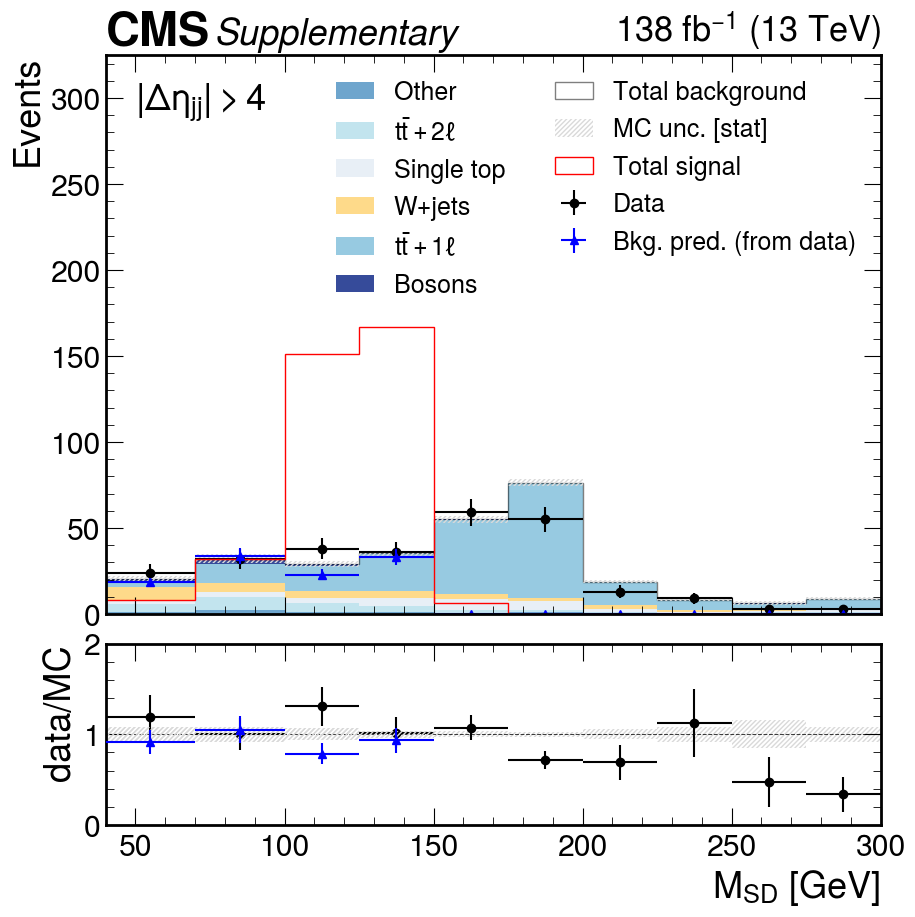

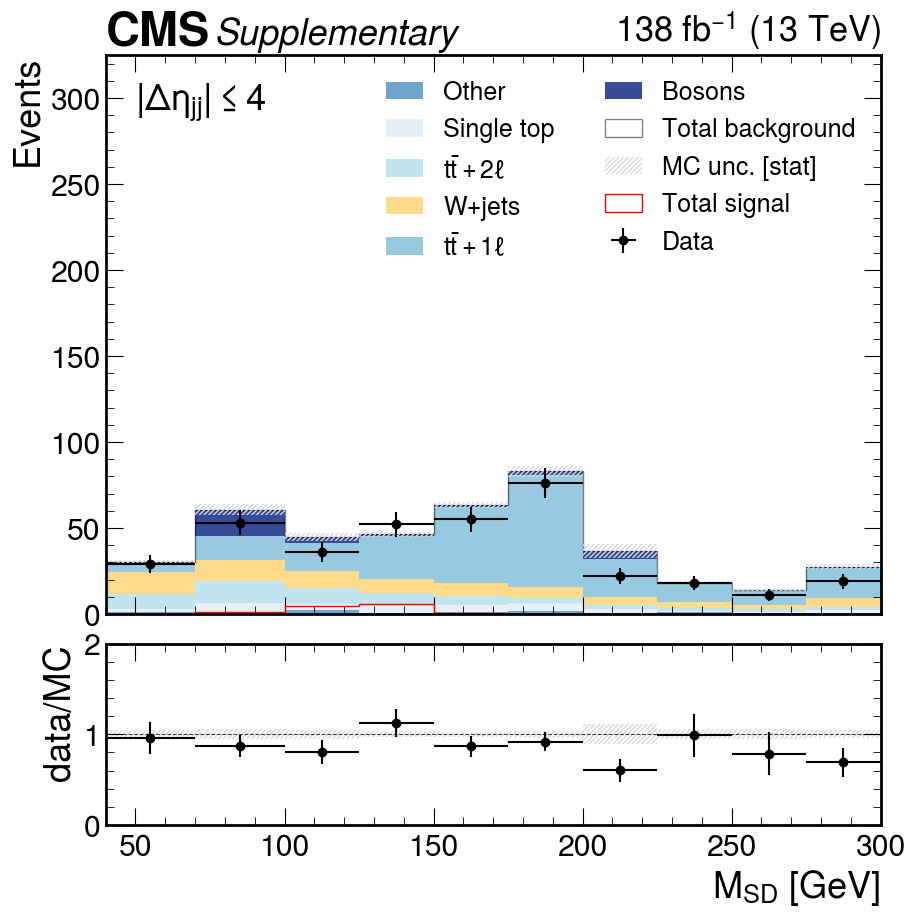

In [15]:
vbswh.cms_label = "Supplementary"

y_max = 325
PLOT_SIGNAL = True
NBINS = 10

column = "hbbjet_msoftdrop"
if NBINS == 6:
    bins = [0, 40, 100, 150, 200, 250, 300]
elif NBINS == 10:
    bins = [0, 20, 40, 70, 100, 125, 150, 175, 200, 225, 250, 275, 300]
else:
    raise Exception("Hello!")

x_label = r"$M_{SD}$ [GeV]"

data_A = vbswh.data_count(selection="regionA")
data_B = vbswh.data_count(selection="regionB")
data_C = vbswh.data_count(selection="regionC")

mc_A = vbswh.bkg_count(selection="regionA")
mc_B = vbswh.bkg_count(selection="regionB")
mc_C = vbswh.bkg_count(selection="regionC")
mc_D = vbswh.bkg_count(selection="regionD")

BtoA = data_A/data_B
BtoA_mc = mc_A/mc_B
mc_fix = (mc_D/mc_C)/BtoA_mc

hist_axes, ratio_axes, (AD_data, AD_bkg, AD_ratio) = vbswh.plot_data_vs_mc(
    column, 
    bins=bins, 
    selection="(regionA or regionD)",
    x_label=x_label,
    stacked=True,
    autoblind=False,
    group_hists={"Other": ["TTX", "VH", "EWKWLep"]},
    legend_counts=False,
    return_hists=True
)

# Get numerator (data) and denominator (bkg MC)
denom_df = vbswh.bkg_df(selection="regionD")
denom = yahist.Hist1D(
    denom_df[column],
    bins=bins,
    weights=denom_df.event_weight,
);
numer_df = vbswh.data_df(selection="regionC")
numer = yahist.Hist1D(
    numer_df[column],
    bins=bins,
    weights=numer_df.event_weight*BtoA*mc_fix,
    label=f"Bkg. pred. (from data)",
    color="b"
);
abcd_stat = np.sqrt(1/data_A + 1/data_B + 1/data_C)
abcd_syst = np.sqrt(0.13**2 + 0.13**2)
numer._errors = numer._counts*BtoA*mc_fix*np.sqrt(abcd_stat**2 + abcd_syst**2)

sig_df = vbswh.sig_df(selection="(regionA or regionD)")
sig = yahist.Hist1D(
    sig_df[column],
    bins=bins,
    weights=sig_df.event_weight,
    label=f"Total signal",
    color="r"
);
AD_sig = sig


# Get ratio
ratio = numer/denom
# Set ratio errors to data relative stat error times the ratio
numer_counts = numer.counts
numer_counts[numer_counts == 0] = 1e-12
ratio._errors = (numer.errors/numer_counts)*ratio.counts

# Plot hists and ratio
numer.plot(ax=hist_axes, errors=True, fmt="^")
ratio.plot(ax=ratio_axes, errors=True, fmt="^", zorder=100)
if PLOT_SIGNAL:
    sig.plot(ax=hist_axes)

# Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
denom_counts = denom.counts
denom_counts[denom_counts == 0] = 1e-12
err_points = np.repeat(denom.edges, 2)[1:-1]
err_high = np.repeat(1 + denom.errors/denom_counts, 2)
err_low = np.repeat(1 - denom.errors/denom_counts, 2)
ratio_axes.fill_between(
    err_points, err_high, err_low,
    step="mid",
    hatch="///////",
    facecolor="none",
    edgecolor=(0.85, 0.85, 0.85),
    linewidth=0.0,
    linestyle="-",
    zorder=2
)

hist_axes.legend(fontsize=18, ncol=2, loc="upper right")
hist_axes.set_ylim(0, y_max)
hist_axes.text(50, 0.9*y_max, r"$|\Delta\eta_{jj}| > 4$")

ratio_axes.set_ylim([0, 2.0])
ratio_axes.legend().remove()

hist_axes.set_xlim(left=40)
ratio_axes.set_xlim(left=40)

if PLOT_SIGNAL:
    plt.savefig(f"{PLOTSDIR}/regionsAD_closure_unblinded_{NBINS}bin_signal.pdf")
else:
    plt.savefig(f"{PLOTSDIR}/regionsAD_closure_unblinded_{NBINS}bin.pdf")


hist_axes, ratio_axes, (BC_data, BC_bkg, BC_ratio) = vbswh.plot_data_vs_mc(
    "hbbjet_msoftdrop", 
    bins=bins, 
    selection="(regionB or regionC)",
    x_label=r"$M_{SD}$ [GeV]",
    stacked=True,
    autoblind=False,
    group_hists={"Other": ["TTX", "VH", "EWKWLep"]},
    legend_counts=False,
    return_hists=True
)

sig_df = vbswh.sig_df(selection="(regionB or regionC)")
sig = yahist.Hist1D(
    sig_df[column],
    bins=bins,
    weights=sig_df.event_weight,
    label=f"Total signal",
    color="r"
);
BC_sig = sig

if PLOT_SIGNAL:
    sig.plot(ax=hist_axes)

hist_axes.legend(fontsize=18, ncol=2, loc="upper right")
hist_axes.set_ylim(0, y_max)
hist_axes.text(50, 0.9*y_max, r"$|\Delta\eta_{jj}| \leq 4$")

ratio_axes.set_ylim([0, 2.0])

hist_axes.set_xlim(left=40)
ratio_axes.set_xlim(left=40)

if PLOT_SIGNAL:
    plt.savefig(f"{PLOTSDIR}/regionsBC_closure_{NBINS}bin_signal.pdf")
else:
    plt.savefig(f"{PLOTSDIR}/regionsBC_closure_{NBINS}bin.pdf")
        
vbswh.cms_label = "Preliminary"



# Create HEPData entry
hepdata_10bin_edges = Variable("Hbb AK8 jet softdrop mass", is_independent=True, is_binned=True, units="GeV")
hepdata_10bin_edges.values = np.stack([bins[:-1], bins[1:]]).T

hepdata_10bin_bkg = Variable("SM Bkg.", is_independent=False, is_binned=False)
hepdata_10bin_bkg.values = AD_bkg.counts
unc_10bin_bkg = Uncertainty("Stat. Unc.")
unc_10bin_bkg.values = AD_bkg.errors
hepdata_10bin_bkg.add_uncertainty(unc_10bin_bkg)

hepdata_10bin_sig = Variable("Signal", is_independent=False, is_binned=False)
hepdata_10bin_sig.values = AD_sig.counts
unc_10bin_sig = Uncertainty("Stat. Unc.")
unc_10bin_sig.values = AD_sig.errors
hepdata_10bin_sig.add_uncertainty(unc_10bin_sig)

hepdata_10bin_data = Variable("Data", is_independent=False, is_binned=False)
hepdata_10bin_data.values = AD_data.counts
unc_10bin_data = Uncertainty("Stat. Unc.")
unc_10bin_data.values = AD_data.errors
hepdata_10bin_data.add_uncertainty(unc_10bin_data)

pred_values = numer.counts
pred_values[pred_values < 0.00001] = 0
hepdata_10bin_pred = Variable("Estimated Bkg.", is_independent=False, is_binned=False)
hepdata_10bin_pred.values = pred_values
unc_10bin_pred = Uncertainty("Stat. + Syst. Unc.")
unc_10bin_pred.values = numer.errors
hepdata_10bin_pred.add_uncertainty(unc_10bin_pred)

table = Table("BSM 10-bin MSD histogram in regions A and D")
table.description = "Histogram of the Hbb AK8 jet softdrop mass for data, simulated signal and background events, and the background yields estimated from data in region A"
table.location = "Additional material"
table.add_image(f"{PLOTSDIR}/regionsAD_closure_unblinded_{NBINS}bin_signal.pdf")
table.add_variable(hepdata_10bin_bkg)
table.add_variable(hepdata_10bin_sig)
table.add_variable(hepdata_10bin_pred)
table.add_variable(hepdata_10bin_data)
table.add_variable(hepdata_10bin_edges)

submission.add_table(table)



hepdata_10bin_bkg = Variable("SM Bkg.", is_independent=False, is_binned=False)
hepdata_10bin_bkg.values = BC_bkg.counts
unc_10bin_bkg = Uncertainty("Stat. Unc.")
unc_10bin_bkg.values = BC_bkg.errors
hepdata_10bin_bkg.add_uncertainty(unc_10bin_bkg)

hepdata_10bin_sig = Variable("Signal", is_independent=False, is_binned=False)
hepdata_10bin_sig.values = BC_sig.counts
unc_10bin_sig = Uncertainty("Stat. Unc.")
unc_10bin_sig.values = BC_sig.errors
hepdata_10bin_sig.add_uncertainty(unc_10bin_sig)

hepdata_10bin_data = Variable("Data", is_independent=False, is_binned=False)
hepdata_10bin_data.values = BC_data.counts
unc_10bin_data = Uncertainty("Stat. Unc.")
unc_10bin_data.values = BC_data.errors
hepdata_10bin_data.add_uncertainty(unc_10bin_data)

table = Table("BSM 10-bin MSD histogram in regions B and C")
table.description = "Histogram of the Hbb AK8 jet softdrop mass for data, simulated signal and background events"
table.location = "Additional material"
table.add_image(f"{PLOTSDIR}/regionsBC_closure_{NBINS}bin_signal.pdf")
table.add_variable(hepdata_10bin_bkg)
table.add_variable(hepdata_10bin_sig)
table.add_variable(hepdata_10bin_data)
table.add_variable(hepdata_10bin_edges)

submission.add_table(table)

# END: Data/MC histograms

# START: LHE histograms

In [16]:
import os
import glob
import uproot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

In [17]:
LUMI = 138

def get_lhe_dfs(lhe_babies, lumi_invfb=138):
    dfs = []
    xsec_df = []
    kW, kZ = (-999, -999)
    for lhe_baby in tqdm(lhe_babies):
        name = lhe_baby.split("/")[-1].replace(".root", "")
        if name == "VBSWH":
            kW, kZ = (1, 1)
        elif "VBSWH_kWkZscan" in name:
            continue
        elif name == "VBSWH_kWscan_kZscan_m1p5_to_m0p5":
            continue
        else:
            if "mkW" in name:
                kW, kZ = (-1, 1)
            elif "mkZ" in name:
                kW, kZ = (1, -1)
            else:
                kV = float(name.split("_")[-1].split("k")[0].replace("p", ".").replace("m", "-"))
                if "kW" in name:
                    kW, kZ = (kV, 1)
                elif "kZ" in name:
                    kW, kZ = (1, kV)
        with uproot.open(lhe_baby) as f:
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            xsec_err = f["Processes"].arrays()[0]["XERRUP"]
            
        # Open ROOT file with uproot and read in TTree as pd.Dataframe
        with uproot.open(lhe_baby) as f:
            df = f.get("tree").arrays(library="pd")
            df["xsec_weight"] = (1000*xsec_pb*lumi_invfb)/len(df)
            df["name"] = name
            
        dfs.append(df)
        xsec_df.append({"name": name, "kW": kW, "kZ": kZ, "xsec": xsec_pb, "xsec_err": xsec_err})
        
    return pd.concat(dfs), pd.DataFrame(xsec_df)

df, xsec_df = get_lhe_dfs(glob.glob(f"{LHEDIR}/*.root"))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  8.09it/s]


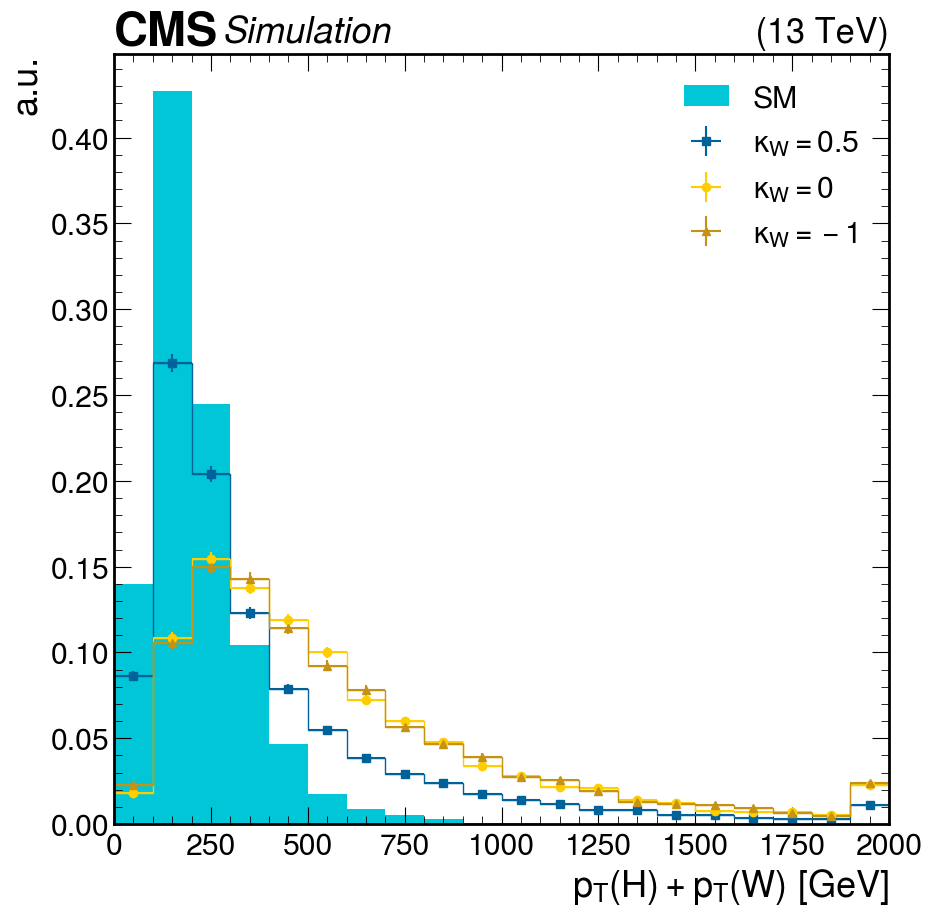

In [18]:
def smart_clip(np_array, bins):
    if len(bins) < 2:
        raise ValueError("must have at least two bins")
        return
    clip_low = 0.5 * (bins[0] + bins[1])
    clip_high = 0.5 * (bins[-2] + bins[-1])
    return np.clip(np_array, clip_low, clip_high)

def plot(df, var, hist_axes=None, bins=None, query="index >= 0", transf=lambda x: x, errors=False, 
         show_events=False, norm=False, label="", alpha=1.0, color=None, hatch=None,
         histtype="stepfilled", fmt="o"):
    
    hist = yahist.Hist1D(
        transf(df.query(query)[var]),
        bins=bins,
        weights=df.query(query).xsec_weight,
        label=(f"{label} [{np.sum(weights):0.1f} events]" if show_events and not norm else label),
        color=color
    )
    if norm:
        hist = hist.normalize()
        
    if not hist_axes is None:
        hist.plot(ax=hist_axes, histtype=histtype, alpha=alpha, errors=errors, fmt=fmt, hatch=hatch)
        
    return hist
    
def plot_all(var, bins=None, query="index >= 0", x_label="", transf=lambda x: x, 
             logy=False, show_events=False, norm=False, outfile=None, W_points=True,
             show_ratio=False):
    global df
    if show_ratio:
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
    else:
        fig, hist_axes = plt.subplots()
        
    if logy:
        hist_axes.set_yscale("log", nonpositive="clip")
        
    table = Table("BSM LHE kinematics plot")
    table.description = "Histogram of pT(H) + pT(W) at the LHE level"
    table.location = "Data from Figure 2"
    
    hepdata_bins = Variable("pT(H) + pT(W)", is_independent=True, is_binned=True, units="GeV")
    hepdata_bins.values = np.stack([bins[:-1], bins[1:]]).T
    table.add_variable(hepdata_bins)

    # Plot SM
    sm_hist = plot(
        df[df.name == "VBSWH"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=False, show_events=show_events, norm=norm,
        label="SM", color="#00C6D7"
    )
    hepdata_var = Variable("SM", is_independent=False, is_binned=False)
    hepdata_var.values = sm_hist.counts
    hepdata_unc = Uncertainty("Stat. Unc.")
    hepdata_unc.values = sm_hist.errors
    hepdata_var.add_uncertainty(hepdata_unc)
    table.add_variable(hepdata_var)
        
    # Plot kW = 0.5
    hist = plot(
        df[df.name == f"VBSWH_0p5k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=True, show_events=show_events, norm=norm,
        label=r"$\kappa_V = 0.5$".replace("V", "W" if W_points else "Z"), color="#00629B",
        histtype="step", fmt="s"
    )
    plot(
        df[df.name == f"VBSWH_0p5k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=False, show_events=show_events, norm=norm,
        color="#00629B", histtype="step"
    )
    hepdata_var = Variable(f"VBSWH k{'W' if W_points else 'Z'} = 0.5", is_independent=False, is_binned=False)
    hepdata_var.values = hist.counts
    hepdata_unc = Uncertainty("Stat. Unc.")
    hepdata_unc.values = hist.errors
    hepdata_var.add_uncertainty(hepdata_unc)
    table.add_variable(hepdata_var)
   
    # Plot kW = 0
    hist = plot(
        df[df.name == f"VBSWH_0k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=True, show_events=show_events, norm=norm,
        label=r"$\kappa_V = 0$".replace("V", "W" if W_points else "Z"), color="#FFCD00",
        histtype="step", fmt="o"
    )
    plot(
        df[df.name == f"VBSWH_0k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=False, show_events=show_events,
        norm=norm, color="#FFCD00", histtype="step"
    )
    hepdata_var = Variable(f"VBSWH k{'W' if W_points else 'Z'} = 0.0", is_independent=False, is_binned=False)
    hepdata_var.values = hist.counts
    hepdata_unc = Uncertainty("Stat. Unc.")
    hepdata_unc.values = hist.errors
    hepdata_var.add_uncertainty(hepdata_unc)
    table.add_variable(hepdata_var)
    
    # Plot kW = -1
    mkW_hist = plot(
        df[df.name == f"VBSWH_mk{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=True, show_events=show_events, norm=norm, 
        label=r"$\kappa_V = -1$".replace("V", "W" if W_points else "Z"), color="#C69214",
        histtype="step", fmt="^"
    )
    mkW_hist = plot(
        df[df.name == f"VBSWH_mk{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins, query=query, transf=transf, errors=False, show_events=show_events, norm=norm, 
        color="#C69214", histtype="step"
    )
    hepdata_var = Variable(f"VBSWH k{'W' if W_points else 'Z'} = 0.5", is_independent=False, is_binned=False)
    hepdata_var.values = mkW_hist.counts
    hepdata_unc = Uncertainty("Stat. Unc.")
    hepdata_unc.values = mkW_hist.errors
    hepdata_var.add_uncertainty(hepdata_unc)
    table.add_variable(hepdata_var)
    
    if show_ratio:
        # Plot (kW = -1)/SM ratio
        ratio_hist = mkW_hist/sm_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2, fmt=" ")

    # Plot legend
    hist_axes.legend();
    # Change axis labels
    hist_axes.set_ylabel("a.u." if norm else "Events");
    # Add CMS label
    hep.cms.label(data=False, loc=0, ax=hist_axes,)
    
    if show_ratio:
        hist_axes.set_xticklabels([])
        ratio_axes.set_xlabel(x_label);
        ratio_axes.set_ylabel(r"$(\kappa_W = -1)/SM$")
        ratio_axes.set_yscale("log");
        ratio_axes.legend().remove()
    else:
        hist_axes.set_xlabel(x_label);
    
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
        plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
        
    table.add_image(outfile)
    submission.add_table(table)
    
    return hist_axes


plot_all(
    "ST", W_points=True, bins=np.linspace(0, 2000, 21), x_label="$p_{T}($H$) + p_{T}($W$)$ [GeV]", 
    show_ratio=False, logy=False, norm=True, outfile=f"{PLOTSDIR}/lhe_ST_kWpoints.pdf"
);

# END: LHE histograms

# START: Tables

In [19]:
# Type       Yield ± Stat. Unc. ± Syst. Unc.
# Signal       366 ±     2.9    ±   68.1
# Background   108 ±    14.4    ±   13.8
# Observed     130

hepdata_SR_sig = Variable("Signal", is_independent=False, is_binned=False)
hepdata_SR_sig.values = [366]
statunc_SR_sig = Uncertainty("Stat. Unc.")
statunc_SR_sig.values = [2.9]
hepdata_SR_sig.add_uncertainty(statunc_SR_sig)
systunc_SR_sig = Uncertainty("Syst. Unc.")
systunc_SR_sig.values = [68.1]
hepdata_SR_sig.add_uncertainty(systunc_SR_sig)

hepdata_SR_bkg = Variable("Background", is_independent=False, is_binned=False)
hepdata_SR_bkg.values = [108]
statunc_SR_bkg = Uncertainty("Stat. Unc.")
statunc_SR_bkg.values = [14.4]
hepdata_SR_bkg.add_uncertainty(statunc_SR_bkg)
systunc_SR_bkg = Uncertainty("Syst. Unc.")
systunc_SR_bkg.values = [13.8]
hepdata_SR_bkg.add_uncertainty(systunc_SR_bkg)

hepdata_SR_obs = Variable("Observed", is_independent=False, is_binned=False)
hepdata_SR_obs.values = [130]

table = Table("BSM signal region yields table")
table.description = "The signal yield estimated by simulation, background yield predicted from data, and observed yield in the signal region."
table.location = "Data from Table 1"
table.add_variable(hepdata_SR_sig)
table.add_variable(hepdata_SR_bkg)
table.add_variable(hepdata_SR_obs)

submission.add_table(table)

# END: Tables

In [20]:
submission.create_files()

Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero content should preferably be omitted completely from the HEPData table.
Note that bins with zero conte